In [1]:
%matplotlib inline


# The Kolmogorov-Smirnov p-value


In this example, we illustrate the calculation of the Kolmogorov-Smirnov p-value. 

* We generate a sample from a gaussian distribution. 
* We create a Uniform distribution with known parameters.
* The Kolmogorov-Smirnov statistics is computed and plot on the empirical cumulated distribution function.
* We plot the p-value as the area under the part of the curve exceeding the observed statistics.



In [2]:
import openturns as ot
import openturns.viewer as viewer
from matplotlib import pylab as plt

ot.Log.Show(ot.Log.NONE)

We generate a sample from a standard gaussian distribution.



In [3]:
dist = ot.Normal()
samplesize = 10
sample = dist.getSample(samplesize)

In [4]:
testdistribution = ot.Normal()
result = ot.FittingTest.Kolmogorov(sample, testdistribution, 0.01)

In [5]:
pvalue = result.getPValue()
pvalue

0.5520956737074482

In [6]:
KSstat = result.getStatistic()
KSstat

0.23684644362352725

Compute exact Kolmogorov PDF.



Create a function which returns the CDF given the KS distance. 



In [7]:
def pKolmogorovPy(x):
    y = ot.DistFunc_pKolmogorov(samplesize, x[0])
    return [y]

In [8]:
pKolmogorov = ot.PythonFunction(1, 1, pKolmogorovPy)

Create a function which returns the KS PDF given the KS distance: use the `gradient` method.



In [9]:
def kolmogorovPDF(x):
    return pKolmogorov.gradient(x)[0, 0]

In [10]:
def dKolmogorov(x, samplesize):
    """
    Compute Kolmogorov PDF for given x.
    x : a Sample, the points where the PDF must be evaluated
    samplesize : the size of the sample
    Reference
    Numerical Derivatives in Scilab, Michael Baudin, May 2009
    """
    n = x.getSize()
    y = ot.Sample(n, 1)
    for i in range(n):
        y[i, 0] = kolmogorovPDF(x[i])
    return y

In [11]:
def linearSample(xmin, xmax, npoints):
    """Returns a sample created from a regular grid 
    from xmin to xmax with npoints points."""
    step = (xmax - xmin) / (npoints - 1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices

In [12]:
n = 1000  # Number of points in the plot
s = linearSample(0.001, 0.999, n)
y = dKolmogorov(s, samplesize)

In [13]:
def drawInTheBounds(vLow, vUp, n_test):
    """
    Draw the area within the bounds.
    """
    palette = ot.Drawable.BuildDefaultPalette(2)
    myPaletteColor = palette[1]
    polyData = [[vLow[i], vLow[i + 1], vUp[i + 1], vUp[i]] for i in range(n_test - 1)]
    polygonList = [
        ot.Polygon(polyData[i], myPaletteColor, myPaletteColor)
        for i in range(n_test - 1)
    ]
    boundsPoly = ot.PolygonArray(polygonList)
    return boundsPoly

Create a regular grid starting from the observed KS statistics.



In [14]:
nplot = 100
x = linearSample(KSstat, 0.6, nplot)

Compute the bounds to fill: the lower vertical bound is zero and the upper vertical bound is the KS PDF.



In [15]:
vLow = [[x[i, 0], 0.0] for i in range(nplot)]
vUp = [[x[i, 0], pKolmogorov.gradient(x[i])[0, 0]] for i in range(nplot)]

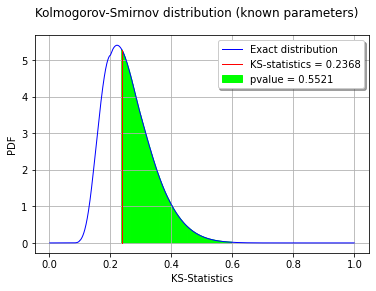

In [16]:
boundsPoly = drawInTheBounds(vLow, vUp, nplot)
boundsPoly.setLegend("pvalue = %.4f" % (pvalue))
curve = ot.Curve(s, y)
curve.setLegend("Exact distribution")
curveStat = ot.Curve([KSstat, KSstat], [0.0, kolmogorovPDF([KSstat])])
curveStat.setColor("red")
curveStat.setLegend("KS-statistics = %.4f" % (KSstat))
graph = ot.Graph(
    "Kolmogorov-Smirnov distribution (known parameters)",
    "KS-Statistics",
    "PDF",
    True,
    "topright",
)
graph.setLegends(["Empirical distribution"])
graph.add(curve)
graph.add(curveStat)
graph.add(boundsPoly)
graph.setTitle("Kolmogorov-Smirnov distribution (known parameters)")
view = viewer.View(graph)
plt.show()
figure = view.getFigure()
figure.savefig("KS_p_value.png", bbox_inches="tight")

We observe that the p-value is the area of the curve which corresponds to the KS distances greater than the observed KS statistics.

